In [18]:
%matplotlib notebook
import random
import numpy as np
from scipy.optimize import least_squares
from numba import jit
import matplotlib.pylab as plt
import matplotlib.animation as animation



    # Point objects stored within the lattice
    # Contain accessible angles and energy

@jit(nopython=True)
def calculateEnergy(size, anglesBox,energyBox, J, row, column, flip = False, deFlip = False): 
           
            
            if flip:
                anglesBox[row][column] = ((anglesBox[row][column] + 45)%360)
            if deFlip:
                anglesBox[row][column] = ((anglesBox[row][column] - 45)%360)
                
            
            firstSpin = anglesBox[row][column]
            pastEnergy = energyBox[row][column]       
            
            dE = np.cos(firstSpin - (anglesBox[((row+1)%size)][column]))
            
            dE += np.cos(firstSpin - (anglesBox[((row-1)%size)][column]))
            
            dE += np.cos(firstSpin - (anglesBox[row][((column+1)%size)]))
            
            dE += np.cos(firstSpin - (anglesBox[row][((column-1)%size)]))


            energy = dE * J
            
            
            energyBox[row][column] = energy
            delta = dE - pastEnergy

        # If flipped return the change in energy 
            if flip:
                return delta
            else:
                return energy
            
            
@jit(nopython=True)
def getTotalEnergy(size, energyBox, beta, exceptionRow = -1, exceptionColumn = -1, calculateW = False):
    
    sigma = 0
    totalEnergy = 0
    for i in range (0, size):
        for j in range(0, size):
            if i == exceptionRow and j == exceptionColumn:
                continue
            if calculateW:
                sigma += np.exp(energyBox[i][j] * (-1 * beta)) 
            totalEnergy += energyBox[i][j] 
    if calculateW:
        return sigma
    else:
        return totalEnergy
        
@jit(nopython=True)
def numerator(beta, energy):
    return np.exp(-1 * beta * energy)
        
            

class lattice:
    def __init__(self, size = 20, temperature = 0.01, J = -1): 
        self.anglesBox = np.zeros(shape = (size, size), dtype = int)
        self.energyBox = np.zeros(shape = (size, size), dtype = float)
        self.size = size
        self.J = J
        self.temperature = temperature
        self.beta = 1/self.temperature
        self.acceptance = 0
        for i in range(0,size):
            for j in range(0,size):
               #self.anglesBox[i][j] = random.randint(0, 360)
               self.anglesBox[i][j] = random.randrange(0, 361, 45)
        self.computeAll()

    # Computes all the Energy in the points at that time.
    # Energy is stored in their respective point object at that index

    def computeAll(self):
        size = self.size
        abox = self.anglesBox
        ebox = self.energyBox
        J = self.J
        for i in range(0, size):
            for j in range(0, size):
                calculateEnergy(size, abox, ebox, J, i, j)
    
    
    # Counts the total energy in the system at that time, includes ALL indices 
    # Use the exception arguments to get all Energy except for the desired step indices

    
    # Seeds a random index and returns the change in energy
    # The energy variable in the point is also changed

    
    def step(self):
        aBox = self.anglesBox
        eBox = self.energyBox
        J = self.J
        beta =self.beta
        size = self.size
        
        randRow = random.randint(0, size-1)
        randColumn = random.randint(0, size-1)

        #Delta is the change in energy

        delta = calculateEnergy(size, aBox, eBox, J, randRow,randColumn, flip = True)
        

        flippedEnergy = eBox[randRow][randColumn]

        if delta > 0:
            self.computeAll()
            Z = getTotalEnergy(size, eBox, beta, exceptionRow = randRow, exceptionColumn = randColumn, calculateW = True)
            sigmaE = numerator(beta, flippedEnergy)
            W = sigmaE/Z
            randomNumber = random.random()
            
            
            self.acceptance += 1

            # If not accepted reject the flip and change energy back

            if W < randomNumber:
                calculateEnergy(size, aBox, eBox, J, randRow, randColumn, deFlip = True)
                self.acceptance -= 1
        else: 
            self.acceptance += 1
    

Traceback (most recent call last):
  File "/Users/omarbrito/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/Users/omarbrito/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/Users/omarbrito/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


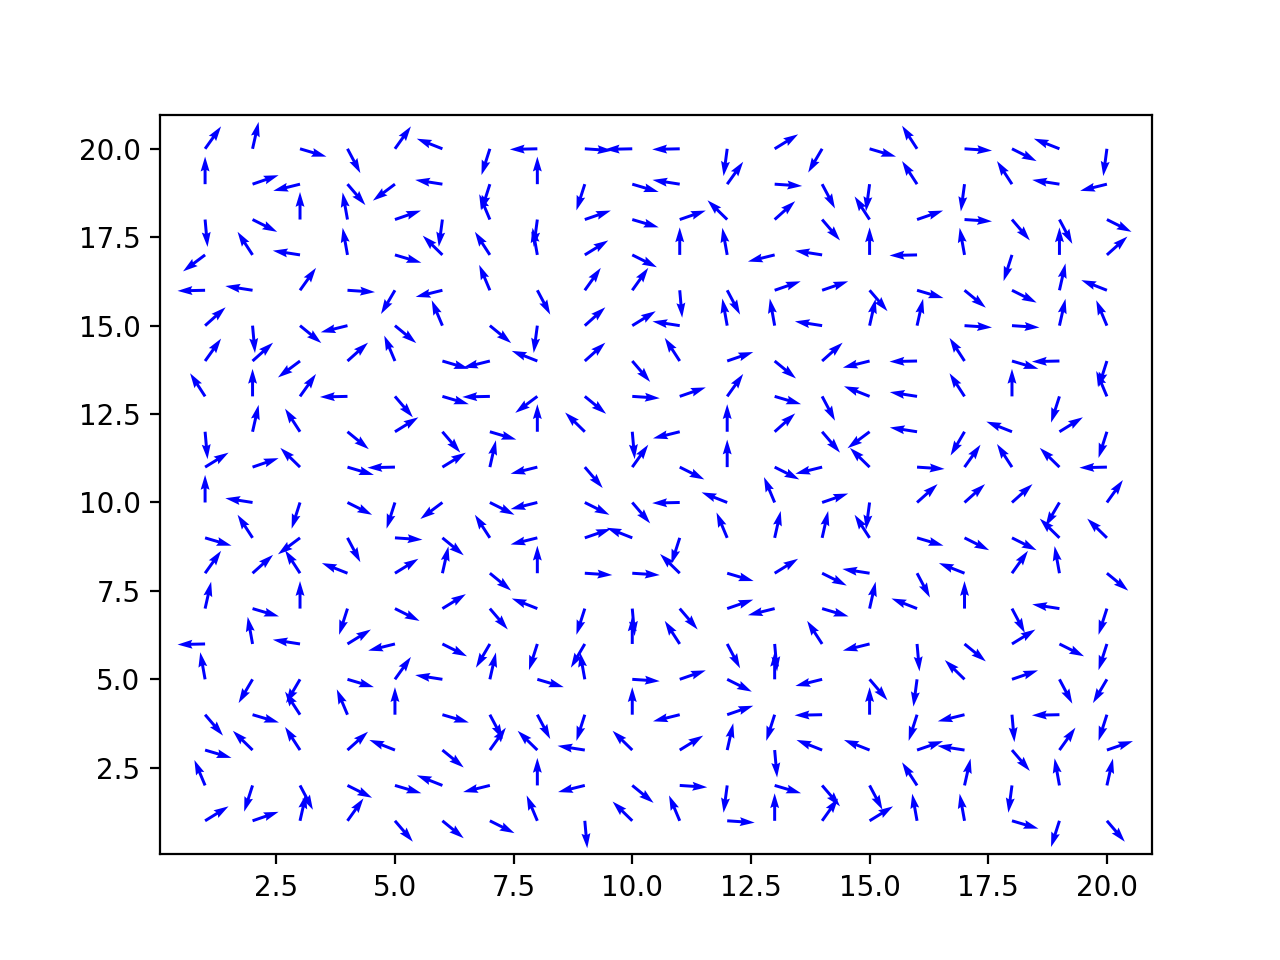

In [19]:
hello = lattice()
size = hello.size
    
lattice_points_oneside = np.linspace(1,size,size)
    
iters_per_step = 50
    
X = []
Y = []
U = np.cos(hello.anglesBox)
V = np.sign(hello.anglesBox)
    
angles = np.array([])
steps = 10000000
angles = np.array([])
    
for i in range(0, size):
    for j in range(0, size):
        angles = np.append(angles, (hello.anglesBox[i][j]))
        
for i in range (0, size):
    X.extend(lattice_points_oneside)
    for ii in range (0, size):
        Y.extend([i+1])
      

fig, ax = plt.subplots(1,1)
arrow_field = ax.quiver(X, Y,np.sin(angles), np.cos(angles), pivot='tail', color='b', units='inches')
        
def update_quiver(num, rects, arrow_field, steps, hello):
    for _ in range(steps):
        hello.step()
        angles = np.array([])
        for i in range(0, size):
            for j in range(0, size):
                angles = np.append(angles, (hello.anglesBox[i][j]))
                    
                    
                    
    U = np.cos(angles)
    V = np.sin(angles)

    arrow_field.set_UVC(U,V)

    return  arrow_field,

ani = animation.FuncAnimation(fig, update_quiver, fargs=(angles, arrow_field, iters_per_step, hello),
                                   interval=10, blit=False, repeat = True)